In [1]:
# Required packages for ploting 
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd 
import os

import geopandas as gpd
from geospatial_functions import get_background_map

data from https://www.epa.gov/ceam/meteorological-data-new-york, download & run all these exe's

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
gis_folder = f'{home_path}\\GIS'
data_folder = f'{home_path}\\Data'

# Handeling meta data

In [3]:
files_description = glob.glob(f'{data_folder}\\EP\\*.txt')

In [4]:
lst_station_data = []
for file in files_description:
    with open(file) as fin:
        for line in fin:
            if line[:19] == "Station WBAN Number":
                search = ": "
                stat_number = int(line[line.find(search)+len(search):].strip())
            if line[:16] == "Station Latitude":
                search = "N   "
                lat = float(line[line.find(search)+len(search):].strip().replace(" degrees ",".").replace(" minutes", "").replace(" ",""))
            if line[:17] == "Station Longitude":
                search = "W   "
                lon = line[line.find(search)+len(search):].strip().replace(" degrees ",".").replace(" minutes", "")
                minutes = lon[lon.find(".")+1:]
                deg =  lon[:lon.find(".")]
                lon = float("-" + deg +  f'{str(int(minutes)/60)[1:]}')
        lst_station_data.append([stat_number,lat,lon])
        

In [5]:
arr_station_data = np.array(lst_station_data)
lst_station_id = list(arr_station_data[:,0])

In [6]:
df = pd.DataFrame(data=lst_station_data,columns=["ID","lat","lon"])
gdf_station = gpd.GeoDataFrame(data=df, geometry=gpd.points_from_xy(df.lon,df.lat),crs="epsg:4326")

loading map layers:

In [7]:
outline           = gpd.read_file(f"{gis_folder}\\hudson_basin.SHP",driver="SHP",crs="EPSG:26918")
main_rivers       = gpd.read_file(f"{gis_folder}\\main_rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
all_rivers        = gpd.read_file(f"{gis_folder}\\rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   

# fixing crs
for layer in [outline,main_rivers,all_rivers]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

In [9]:
# outline.plot(ax=ax, edgecolor="C3", facecolor="None")
# main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
# all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)

# loading data:

In [10]:
files = glob.glob(f'{data_folder}\\EP\\*.dvf')

In [11]:
cols = [
"Date",
"Precipitation" ,         
"Pan Evaporation" ,       
"Temperature (mean)",   
"Wind Speed @10 meter",   
"Solar Radiation ",
"FAO Short Grass Eto",
"Daylight Station Pressure ",
"Daylight Relative Humidity",
"Daylight Opaque Sky Cover",
"Daylight Temperature",
"Daylight Broadband Aerosol",
"Daylight Prevailing Wind Speed @10 meter",
"Daylight Prevailing Wind Direction"]

In [12]:
len(cols)

14

In [13]:
lst_df_evap = []
for file in files:
    df = pd.read_csv(file,delimiter=" ",engine="python",skipinitialspace=True,names=cols)
    df.index = df.apply(lambda x: pd.Timestamp(int(f"19{str(int(x.Date))[-2:]}"),    # year
                                               int(str(int(x.Date))[:-4]),           # month
                                               int(str(int(x.Date))[-4:-2])),axis=1) # day
    df.drop(columns=["Date"],inplace=True)
    df["Pan Evaporation"] = df["Pan Evaporation"] * 100
    lst_df_evap.append(df)

<AxesSubplot: xlabel='mm/d'>

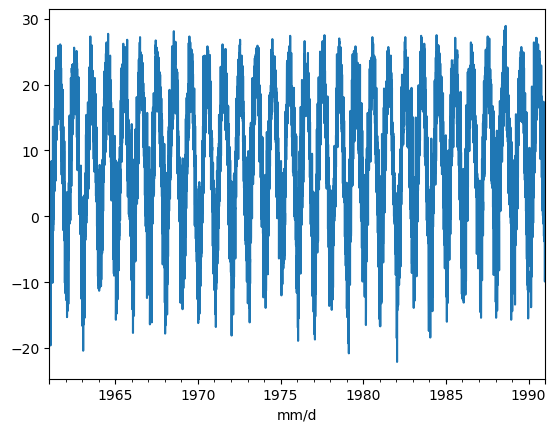

In [20]:
lst_df_evap[1]["Temperature (mean)"].plot()

<AxesSubplot: >

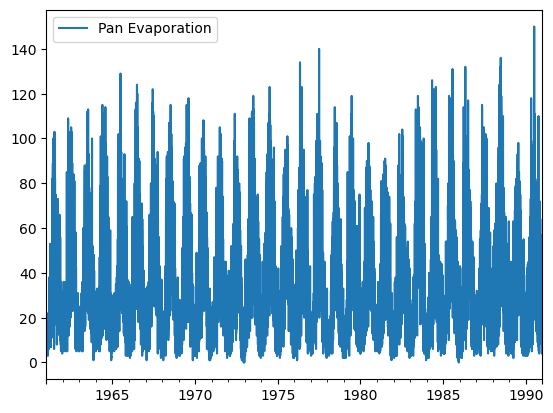

In [14]:
lst_df_evap[1][["Pan Evaporation"]].plot()

In [15]:
for index, df in enumerate(lst_df_evap) :
    df_out = df[["Pan Evaporation"]]
    df_out.index.name = 'mm/d'
    df_out.to_parquet(f'{data_folder}\\EP\\{lst_station_id[index]}.parquet')

In [16]:
pd.read_parquet(f'{data_folder}\\EP\\{lst_station_id[0]}.parquet')

,Pan Evaporation
mm/d,
1961-01-01,6.0
1961-01-02,6.0
1961-01-03,2.0
1961-01-04,7.0
1961-01-05,5.0
...,...
1990-12-27,8.0
1990-12-28,6.0
1990-12-29,20.0


Seems too high however, so disgregarded: instead use try era5